In [1]:
from numpy.random import Generator
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
from scipy.optimize import minimize 
from scipy.stats import gaussian_kde
from scipy.stats import ks_2samp
from scipy.special import rel_entr

In [2]:
try:
    plt.style.use('neuroblu')
except:
    print('neuroblu style not found. Using default style!')

In [3]:
config = {
    'nbase': 200,
    'neca': 1000,
    'nwaypoints': 20
}

In [4]:
def plot_dist(data1, data2, col, ax=None):
    if not ax:
        _, ax = plt.subplots(1,1)
        
    ax.hist(data1[col], density=True, fill='black', histtype='stepfilled', 
             edgecolor='black', bins= 10, linewidth=1.2, label=data1.name)
    ax.hist(data2[col], density=True, bins= 10, fill='blue', histtype='stepfilled',
             edgecolor='blue', linewidth=1.2, label=data2.name, alpha=0.7)
    ax.legend(loc='best')
    ax.set_title(col)
    return 

In [5]:
# For Base cohort
age = 45
lab1 = 3.4
lab2 = 5000

mean = [age, lab1, lab2]
cov = [[14, 3, 100], 
       [3, 2, 50],
       [100, 50, 25000]]

np.random.seed(42)
x = np.random.multivariate_normal(mean, cov, config['nbase'])
x[x< 0] = 0

lab3 = np.random.beta(1, 2, size=config['nbase'])
x = np.concatenate((x, lab3.reshape(config['nbase'], -1)), axis=1)

cond1 = np.random.binomial(1, 0.3, size=config['nbase']).reshape(config['nbase'], -1)
x = np.concatenate((x, cond1), axis=1)

cat1 = np.random.binomial(3, 0.5, size=config['nbase']).reshape(config['nbase'], -1)
x = np.concatenate((x, cat1), axis=1)

data_base = pd.DataFrame(x, columns=['age', 'lab1', 'lab2', 'lab3', 'cond1', 'cat1'])

In [6]:
# For External cohort
age = 50
lab1 = 5.5
lab2 = 4800

mean = [age, lab1, lab2]
cov = [[20, 5, 150], 
       [5, 4, 100],
       [150, 100, 55000]]

x = np.random.multivariate_normal(mean, cov, config['neca'])
x[x< 0] = 0

lab3 = 1.5*np.random.beta(1, 2, size=config['neca'])
x = np.concatenate((x, lab3.reshape(config['neca'], -1)), axis=1)

cond1 = np.random.binomial(1, 0.5, size=config['neca']).reshape(config['neca'], -1)
x = np.concatenate((x, cond1), axis=1)

cat1 = np.random.binomial(3, 0.7, size=config['neca']).reshape(config['neca'], -1)
x = np.concatenate((x, cat1), axis=1)

data_eca = pd.DataFrame(x, columns=['age', 'lab1', 'lab2', 'lab3', 'cond1', 'cat1'])

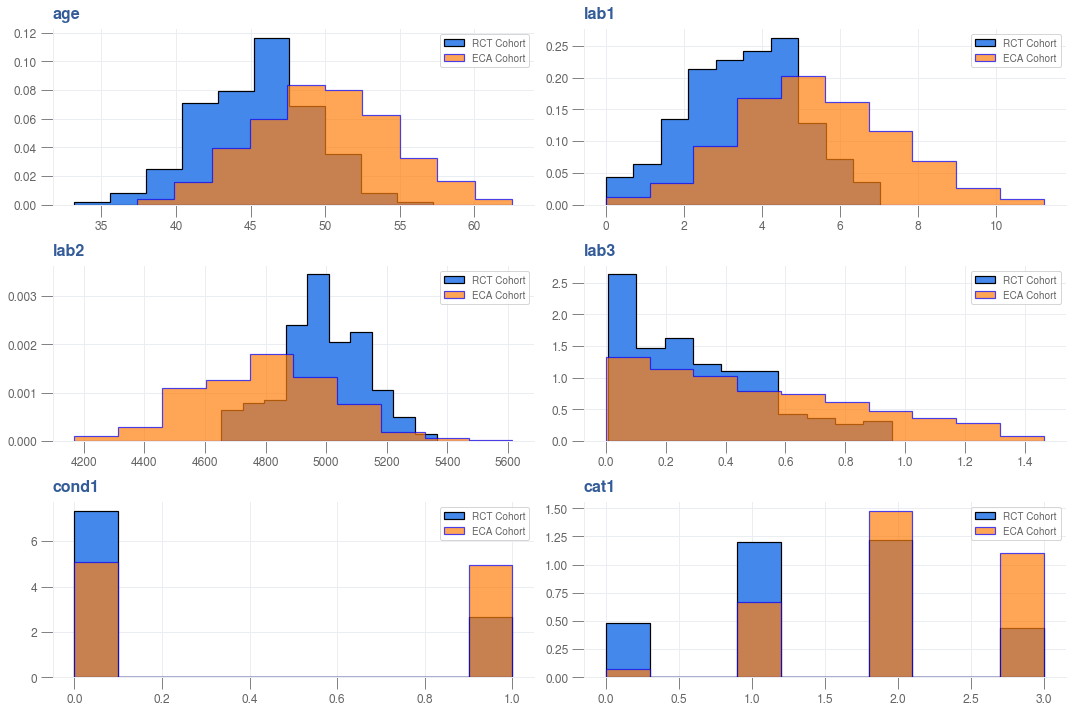

In [7]:
_, ax = plt.subplots(3,2, figsize=(15, 10))

data_base.name = 'RCT Cohort'
data_eca.name = 'ECA Cohort'
plot_dist(data_base, data_eca, 'age', ax[0][0])
plot_dist(data_base, data_eca, 'lab1', ax[0][1])
plot_dist(data_base, data_eca, 'lab2', ax[1][0])
plot_dist(data_base, data_eca, 'lab3', ax[1][1])
plot_dist(data_base, data_eca, 'cond1', ax[2][0])
plot_dist(data_base, data_eca, 'cat1', ax[2][1])

In [8]:
density_age = gaussian_kde(data_base['age'])
density_lab1 = gaussian_kde(data_base['lab1'])
density_lab2 = gaussian_kde(data_base['lab2'])
density_lab3 = gaussian_kde(data_base['lab3'])
density_cond1 = gaussian_kde(data_base['cond1'])
density_cat1 = gaussian_kde(data_base['cat1'])

In [9]:
b = max(data_base['age'].max(), data_eca['age'].max())
a = min(data_base['age'].min(), data_eca['age'].min())
waypoints_age = np.linspace(a, b, config['nwaypoints'])

b = max(data_base['lab1'].max(), data_eca['lab1'].max())
a = min(data_base['lab1'].min(), data_eca['lab1'].min())
waypoints_lab1 = np.linspace(a, b, config['nwaypoints'])

b = max(data_base['lab2'].max(), data_eca['lab2'].max())
a = min(data_base['lab2'].min(), data_eca['lab2'].min())
waypoints_lab2 = np.linspace(a, b, config['nwaypoints'])

b = max(data_base['lab3'].max(), data_eca['lab3'].max())
a = min(data_base['lab3'].min(), data_eca['lab3'].min())
waypoints_lab3 = np.linspace(a, b, config['nwaypoints'])

b = max(data_base['cond1'].max(), data_eca['cond1'].max())
a = min(data_base['cond1'].min(), data_eca['cond1'].min())
waypoints_cond1 = np.linspace(a, b, config['nwaypoints'])

b = max(data_base['cat1'].max(), data_eca['cat1'].max())
a = min(data_base['cat1'].min(), data_eca['cat1'].min())
waypoints_cat1 = np.linspace(a, b, config['nwaypoints'])

In [10]:
barwidth_age = np.diff(waypoints_age)[0]
barwidth_lab1 = np.diff(waypoints_lab1)[0]
barwidth_lab2 = np.diff(waypoints_lab2)[0]
barwidth_lab3 = np.diff(waypoints_lab3)[0]
barwidth_cond1 = np.diff(waypoints_cond1)[0]
barwidth_cat1 = np.diff(waypoints_cat1)[0]

In [11]:
kde_age = density_age(waypoints_age)*barwidth_age
kde_lab1 = density_lab1(waypoints_lab1)*barwidth_lab1
kde_lab2 = density_lab2(waypoints_lab2)*barwidth_lab2
kde_lab3 = density_lab3(waypoints_lab3)*barwidth_lab3
kde_cond1 = density_cond1(waypoints_cond1)*barwidth_cond1
kde_cat1 = density_cat1(waypoints_cat1)*barwidth_cat1

In [12]:
def calc_loss(w):    
    est_den_age = gaussian_kde(data_eca['age'], weights=w)
    est_den_lab1 = gaussian_kde(data_eca['lab1'], weights=w)
    est_den_lab2 = gaussian_kde(data_eca['lab2'], weights=w)
    est_den_lab3 = gaussian_kde(data_eca['lab3'], weights=w)
    est_den_cond1 = gaussian_kde(data_eca['cond1'], weights=w)
    est_den_cat1 = gaussian_kde(data_eca['cat1'], weights=w)

#     loss = ((kde_age - est_den_age(waypoints_age))*barwidth_age)**2 + \
#     ((kde_lab1 - est_den_lab1(waypoints_lab1))*barwidth_lab1)**2 + \
#     ((kde_lab2 - est_den_lab2(waypoints_lab2))*barwidth_lab2)**2 + \
#     ((kde_lab3 - est_den_lab3(waypoints_lab3))*barwidth_lab3)**2 + \
#     ((kde_cond1 - est_den_cond1(waypoints_cond1))*barwidth_cond1)**2 + \
#     ((kde_cat1 - est_den_cat1(waypoints_cat1))*barwidth_cat1)**2

    loss = rel_entr(kde_age, est_den_age(waypoints_age))*barwidth_age + \
           rel_entr(kde_lab1, est_den_lab1(waypoints_lab1))*barwidth_lab1 + \
           rel_entr(kde_lab2, est_den_lab2(waypoints_lab2))*barwidth_lab2 + \
           rel_entr(kde_lab3, est_den_lab3(waypoints_lab3))*barwidth_lab3 + \
           rel_entr(kde_cond1, est_den_cond1(waypoints_cond1))*barwidth_cond1 + \
           rel_entr(kde_cat1, est_den_cat1(waypoints_cat1))*barwidth_cat1
        
    return sum(loss)

In [13]:
cons = ({'type': 'eq', 'fun': lambda x: sum(x) - 1})

In [14]:
%%time
weights = np.ones(config['neca'])/config['neca']

bounds = list(zip(np.zeros(config['neca']), np.ones(config['neca'])))
wopt = minimize(calc_loss, weights, constraints=cons, options= 
            {"disp":True,"maxiter":1000}, bounds=bounds)
p = wopt.x

Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: 329.0825652965871
            Iterations: 154
            Function evaluations: 150482
            Gradient evaluations: 150
CPU times: user 21min 39s, sys: 2.4 s, total: 21min 42s
Wall time: 21min 41s


In [15]:
wopt.success

False

In [16]:
data_eca_study = data_eca.sample(n=config['nbase'], replace=True, weights=p, 
                                 random_state=42)
data_eca_study.name = 'ECA'

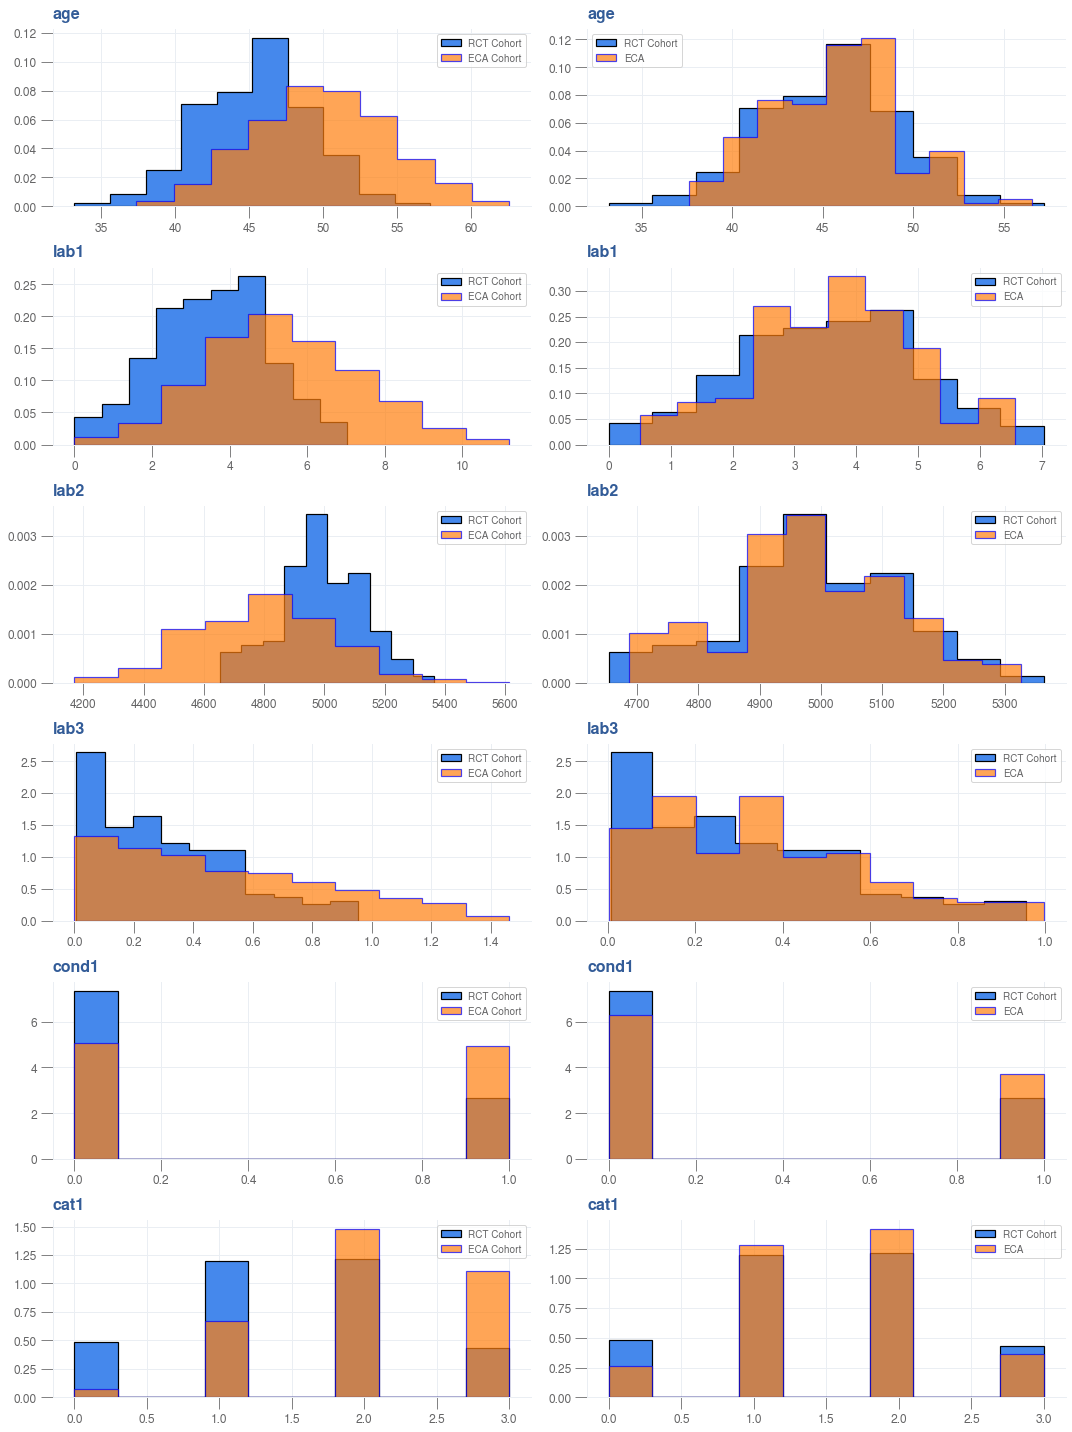

In [17]:
_, ax = plt.subplots(6,2, figsize=(15, 20))

for i, col in enumerate(data_base.columns):
    plot_dist(data_base, data_eca, col, ax[i][0])
    plot_dist(data_base, data_eca_study, col, ax[i][1])

In [18]:
for col in data_base.columns:
    print(f'Distribution of {col}')
    print('Before balancing', ks_2samp(data_base[col], data_eca[col]))
    print('After balancing', ks_2samp(data_base[col], data_eca_study[col]))
    print('\n')

Distribution of age
Before balancing KstestResult(statistic=0.438, pvalue=3.3306690738754696e-16)
After balancing KstestResult(statistic=0.07, pvalue=0.7125821300149116)


Distribution of lab1
Before balancing KstestResult(statistic=0.434, pvalue=3.3306690738754696e-16)
After balancing KstestResult(statistic=0.105, pvalue=0.220541217580421)


Distribution of lab2
Before balancing KstestResult(statistic=0.46, pvalue=3.3306690738754696e-16)
After balancing KstestResult(statistic=0.085, pvalue=0.46628639073563594)


Distribution of lab3
Before balancing KstestResult(statistic=0.279, pvalue=6.6097127771058695e-12)
After balancing KstestResult(statistic=0.12, pvalue=0.11228360286766195)


Distribution of cond1
Before balancing KstestResult(statistic=0.229, pvalue=3.9603319401670944e-08)
After balancing KstestResult(statistic=0.105, pvalue=0.220541217580421)


Distribution of cat1
Before balancing KstestResult(statistic=0.281, pvalue=4.496847338941734e-12)
After balancing KstestResult(statis